## Deep Energy-based Models and Adversarial Training

In this notebook, we will look at energy-based deep learning models (EBM), and focus on their application as generative models. \
We investigate the relationship between adversarial training (AT) and EBM.

Credit : 

**[1]** Phillip Lippe https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial8/Deep_Energy_Models.html \
**[2]** JEM https://github.com/wgrathwohl/JEM \
**[3]** JEM++ https://github.com/sndnyang/JEMPP \
**[4]** JEAT https://arxiv.org/pdf/2108.09093.pdf

Experiments follows as much as possibile the setting of **[2]** and **[4]**.

### Import basic libraries

In [1]:
! pip install kornia
! pip install torchattacks
! pip install netcal
! pip install torchsummary
! pip install git+https://github.com/RobustBench/robustbench.git

  Cloning https://github.com/RobustBench/robustbench.git to /tmp/pip-req-build-s0gjwa42
  Running command git clone --filter=blob:none --quiet https://github.com/RobustBench/robustbench.git /tmp/pip-req-build-s0gjwa42
  Resolved https://github.com/RobustBench/robustbench.git to commit a59504facfea36a0c9d916830b6c29e9cd45bc9b
  Preparing metadata (setup.py) ... done
  Using cached autoattack-0.1-py3-none-any.whl


In [2]:
import torch
import numpy as np
import sklearn
import scipy
import pandas as pd
import torch
import matplotlib.pyplot as plt

import torchvision
from typing import *
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader

from torch.nn import functional as F
from torch.nn import Conv2d
from torch.nn import MaxPool2d as MaxPool2d
from tqdm import tqdm
import torchvision.models as models
import torchvision.datasets as datasets 
import torchvision.transforms as tr

from robustbench.utils import load_model
import os

reproducability stuff

In [3]:
#REPRODUCIABILYT STUFF

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

import random
torch.manual_seed(0)
np.random.seed(0)
random.seed(45)

Using device: cuda:0


In [4]:
from torchvision.transforms.transforms import RandomGrayscale
from torch.utils.data import random_split
from ipywidgets import IntProgress


#stddev of gaussian noise to add to input, 0.03 works but 0.1 is more stable"
sigma = 3e-2 


transform_train = tr.Compose(
            [tr.Pad(4, padding_mode="reflect"),
             tr.RandomCrop(32),
             tr.RandomHorizontalFlip(),
             tr.ToTensor(),
             #tr.Normalize((.5, .5, .5), (.5, .5, .5)),
             #lambda x: x + sigma * torch.randn_like(x)
            ]
        )

transform_test = tr.Compose(
        [ tr.ToTensor(),
         #tr.Normalize((.5, .5, .5), (.5, .5, .5)),
         #lambda x: x + sigma * torch.randn_like(x) 
        ]
        
        )


#dataset CIFAR10
dataset_cifar10 = datasets.CIFAR10("/data_cifar10", train=True, download=True, transform=transform_train)
test_set_cifar10 = datasets.CIFAR10("/data_cifar10", train=False, download=True, transform = transform_test)


#create validation validation set 
train_set_cifar10, val_set_cifar10 = random_split(dataset_cifar10, [45000, 5000])


# build the dataloaders CIFAR10
train_loader_cifar10 = torch.utils.data.DataLoader( train_set_cifar10, batch_size=128, shuffle=True, num_workers=20 )
val_loader_cifar10 = torch.utils.data.DataLoader( val_set_cifar10, batch_size=64, shuffle=True, num_workers=20 )
test_loader_cifar10 = torch.utils.data.DataLoader( test_set_cifar10, batch_size=64, shuffle=True, num_workers=20 )


##########################################################################################

#dataset CIFAR100

dataset_cifar100 = datasets.CIFAR100("/data_cifar100", train=True, download=True, transform=transform_train)
test_set_cifar100 = datasets.CIFAR100("/data_cifar100", train=False, download=True, transform=transform_test)


#create validation validation set 
train_set_cifar100, val_set_cifar100 = random_split(dataset_cifar100, [45000, 5000])


# build the dataloader for CIFAR100
train_loader_cifar100 = torch.utils.data.DataLoader( train_set_cifar100, batch_size=128, shuffle=True, num_workers=20)
val_loader_cifar100 = torch.utils.data.DataLoader( val_set_cifar100, batch_size=64, shuffle=True, num_workers=20 )
test_loader_cifar100 = torch.utils.data.DataLoader( test_set_cifar100, batch_size=64, shuffle=True, num_workers=20 )

Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Files already downloaded and verified
Files already downloaded and verified


tensor(0.9922)
torch.Size([3, 32, 32])


Text(0.5, 0, 'Some images of Cifar-10')

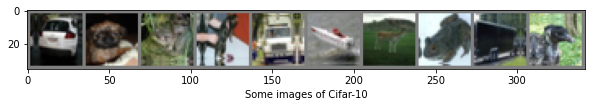

In [5]:
batch = (next(iter(train_loader_cifar10)))[0]
print(torch.max(batch[0]))
print(batch[0].shape)


grid = torchvision.utils.make_grid(batch[:10], nrow=batch.shape[0], normalize=True, value_range=(0,1), pad_value=0.5, padding=2)
grid = grid.permute(1, 2, 0)
plt.figure(figsize=(10,10))
plt.imshow(grid)
plt.xlabel("Some images of Cifar-10")

## Utils functions (Adv. Training, Validation and Testing robustness)

In [6]:
from tqdm import tqdm
from sklearn.metrics import precision_recall_curve
from numpy import argmax
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import det_curve
from sklearn.metrics import DetCurveDisplay
import matplotlib
import seaborn as sns
import pandas as pd
import torchattacks


# change size of matplotlib pictures
SMALL_SIZE = 15
MEDIUM_SIZE = 16
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=SMALL_SIZE)  # fontsize of the figure title


best_acc = 0  # best test accuracy


def adversarial_training_pgd(epoch, loader , net, optimizer, loss_func, log_freq, epsilon, steps, step_size):

    net.train()
    running_loss=0
    correct = 0
    total = 0
    losses = []
    

    for batch_idx, (inputs, targets) in enumerate(tqdm(loader)):
        
        inputs, targets = inputs.to(device), targets.to(device)
        
        atk = torchattacks.PGD(net, eps=epsilon, alpha=step_size, steps=steps)
        #atk.set_normalization_used(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        
        
        adv_images = atk(inputs, targets)
        
        optimizer.zero_grad()

        outputs = net(adv_images)

        loss = loss_func(outputs, targets)

        running_loss += loss.item()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum().item()
        
        # print statistics every log_freq mini batch
        if (batch_idx+1) % log_freq == 0:    # print every log_freq mini batches
            print('[Epoch : %d, Iter: %5d] loss: %.3f' %
                  (epoch + 1, batch_idx, running_loss / log_freq))
            losses.append( running_loss / log_freq)
            running_loss = 0.0
            print('Adv. Accuracy on Training set %s with PGD attack with eps= %s, num_steps=%s, step_size=%s' % (correct / total, epsilon, steps, step_size) )
            correct=0
            total=0
        
    return losses



# validation clean images
def validation(i, net, loader, loss_func, url_name_model):

    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    correct3 = 0
    correct5 = 0
    total = 0
    folder_save = url_name_model

    with torch.no_grad():

        for batch_idx, (inputs, targets) in enumerate(tqdm(loader)):
            
            inputs, targets = inputs.to(device), targets.to(device)
            
            outputs = net(inputs)
            loss = loss_func(outputs, targets)

            test_loss += loss.item()

            #top1 accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += predicted.eq(targets.data).cpu().sum().item()

            #top3 accuracy
            targets_resize = targets.view(-1,1)
            _, predicted3 = outputs.topk(3, 1, True, True)
            correct3 += torch.eq(predicted3, targets_resize).sum().float().item()
                
            #top5 accuracy
            _, predicted5 = outputs.topk(5, 1, True, True)
            correct5 += torch.eq(predicted5, targets_resize).sum().float().item()
        
        print('Top1 accuracy of the network on val set:', 100.*correct / total)
        print('Top3 accuracy of the network on valmset:', 100.*correct3 / total)
        print('Top5 accuracy of the network on val set:', 100.*correct5 / total)

        # Save checkpoint.
        
        acc = 100.*correct/total
        if acc > best_acc:
            print('Saving..')
            torch.save({
                'epoch': i,
                'model_state_dict': net.state_dict(),
                }, folder_save)
            best_acc = acc

            
            
def test_robustness_pgd(model, loader, epsilon, alpha, steps, printt=True):

        """
            test robustness with PGD 
        """
        
        atk = torchattacks.PGD(model, eps=epsilon, alpha=alpha, steps=steps)
        #atk.set_normalization_used(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        
        net.eval()
        correct = 0
        test_loss_adv = 0
        correct_adv = 0
        loss_func = nn.CrossEntropyLoss()
        
        for data, target in tqdm(loader):
            
            data, target = data.to(device), target.to(device)
            
            #clean accuracy
            output = model(data)
            _, predicted = torch.max(output.data, 1)
            correct += predicted.eq(target.data).cpu().sum().item()
    
            # print adversarial accuracy
            data_adv = atk(data, target)
            output_adv = model(data_adv)
            _, predicted = torch.max(output_adv.data, 1)
            correct_adv += predicted.eq(target.data).cpu().sum().item()

            
        if printt == True:
            print('Clean Accuracy: {}/{} ({:.0f}%)\n'.format(
                correct, len(loader.dataset),
                100. * correct / len(loader.dataset)))

            print('Adv Accuracy: {}/{} ({:.0f}%)\n'.format(
                 correct_adv, len(loader.dataset),
                100. * correct_adv / len(loader.dataset)))
        else: 
            return 100. * correct_adv / len(loader.dataset)


## Stochastic Gradient Langevin Dynamics (SGLD)

In [194]:
""" Define the loss in the samplling optimization.
    
    E(x) = - Log[ Sum( exp( logits ) ) ]
    E(x,y) = - Log[ exp( logits[y] ) ]
    Cross_Entropy = E(x,y) - E(x)

"""


def energy(logits):
    
    energy = (- torch.log ( torch.sum ( torch.exp(logits),1 ) )).mean()

    return energy
    

def energy_x_y(logits, labels):
    
    return (- torch.gather(logits.to(device), 1, labels[:,None])).sum()
    




def SGLD(model, inp_imgs, batch_size=10, labels=None, steps=20, step_size=1, mode="PreJEAT"):

        """
        Standard Stochastic Gradient Langevin Dynamics.
        Function for getting a new batch of "fake" images.
        Inputs:
            model : an andversarial trained neural network
            inp_imgs : batch with well-initialized data (X-0)
            steps - Number of iterations in the MCMC algorithm
            step_size - Learning rate nu of the SGLD
            mode : one of ["PreJEAT", "energy", "Cross_Entropy"]
        """
        
        inp_imgs = inp_imgs.clone().detach().to(device)
        
        samples = inp_imgs.clone().detach()

        # We use a buffer tensor in which we generate noise each loop iteration.
        noise = torch.randn(inp_imgs.shape, device=inp_imgs.device)
                
        
        for _ in range(steps):
            
            samples.requires_grad = True
            
            logits = model(samples)
            
            if mode == "PreJEAT":
                cost = energy_x_y(logits, labels)
                    
            if mode == "Cross_Entropy":
                loss = nn.CrossEntropyLoss()
                cost = loss(logits, labels)

                
            if mode == "energy":
                cost = energy(logits)
                
            
            #Part 2: add noise
            rumore = noise.normal_(0, 0.01)
    
            #gradient compute   
            grad = torch.autograd.grad(cost, samples,
                                       retain_graph=False, create_graph=False)[0]
            
            samples = samples.detach() - step_size/2 * grad + np.sqrt(step_size)*rumore
            
            samples.data.clamp_(min=0, max=1.0)
            #samples = torch.sigmoid(samples)

        return samples
    

### Starting Point $\mathbf{x}_0$

In [195]:
""" 
    Starting point is crucial for the convergence of SGLD
    Credit : JEM++ 

"""

conditionals = []


def category_mean(dload_train, n_class = 10):
    
    if not os.path.exists('./data/'):
        os.mkdir('./data/')
        
    if os.path.exists('./data/s_mean_Cifar10.pt') and os.path.exists('./data/s_cov_Cifar10.pt'):
        print('> Mean and Covariance Already Computed, skipping')
        return

    size = [3, 32, 32]
    centers = torch.zeros( [n_class, int(np.prod((3,32,32))) ])
    covs = torch.zeros([n_class, int(np.prod((3,32,32))), int(np.prod((3,32,32))) ])

    #take all images from the dataloader
    im_test, targ_test = [], []
    for im, targ in dload_train:
        im_test.append(im)
        targ_test.append(targ)
    im_test, targ_test = torch.cat(im_test), torch.cat(targ_test)

    for i in range(n_class):
        
        imc = im_test[targ_test == i]
        imc = imc.view(len(imc), -1)
        mean = imc.mean(dim=0)
        sub = imc - mean.unsqueeze(dim=0)
        cov = sub.t() @ sub / len(imc)
        centers[i] = mean
        covs[i] = cov
        torch.save(imc, f"./data/img_class_{i}.pt")
        
    torch.save(centers, "./data/s_mean_Cifar10.pt")
    torch.save(covs, "./data/s_cov_Cifar10.pt")

    

    

def init_from_centers(dataset, buffer_size=0, n_class=10):
    
    """
    Sample from a Multivariate Normal Distribution
    dataset : one of ["Cifar10", "tinyimagenet", "svhn"]
    buffer_size = buffer size
    
    """
    
    global conditionals
    from torch.distributions.multivariate_normal import MultivariateNormal
    
    
    if dataset == 'tinyimagenet':
        size = [3, 64, 64]
    elif dataset == 'svhn':
        size = [3, 32, 32]
    else:
        size = [3, 32, 32]
    
    centers = torch.load("./data/s_mean_" + dataset + ".pt")
    covs = torch.load("./data/s_cov_"+ dataset + ".pt")

    buffer = []
    for i in range(n_class):
        
        mean = centers[i].to(device)
        cov = covs[i].to(device)
        dist = MultivariateNormal(mean, covariance_matrix=cov + 1e-4 * torch.eye(int(np.prod(size))).to(device) )
        buffer.append( dist.sample((buffer_size // n_class, )).view([buffer_size // n_class] + size).cpu() )
        conditionals.append(dist)
        
    return torch.clamp(torch.cat(buffer), 0, 1)



def init_random(batch_size, n_class=10):
    
    """ batch_size : batch size
    """
    
    global conditionals
    
    n_ch = 3
    size = [3, 32, 32]
    im_sz = 32
    
    new = torch.zeros(batch_size, n_ch, im_sz, im_sz)
    
    for i in range(batch_size):
        index = np.random.randint(n_class)
        dist = conditionals[index]
        new[i] = dist.sample().view(size)
        
    return torch.clamp(new, 0, 1).cpu()




def sample_p_0(replay_buffer, bs, y=None, n_class=10):
    
    """ replay_buffer : buffer with data 
        bs : batch size
    """
    
    if len(replay_buffer) == 0:
        return init_random(bs), []
    

    buffer_size = len(replay_buffer) if y is None else len(replay_buffer) // n_class
    
    inds = torch.randint(0, buffer_size, (bs,))
    
    # if cond, convert inds to class conditional inds
    if y is not None:
        inds = y.cpu() * buffer_size + inds
        
    buffer_samples = replay_buffer[inds]
    random_samples = init_random(bs)
    
    choose_random = (torch.rand(bs) < 0.05).float()[:, None, None, None]
    samples = choose_random * random_samples + (1 - choose_random) * buffer_samples
    
    return samples.to(device), inds




### Load Pre-trained ResNet


We load the ResNet-50 pre-trained model from robustbench which it loads the model from Robustness library (MadryLab).

In [196]:
from robustbench.utils import load_model

model = load_model(model_name='Engstrom2019Robustness', dataset='cifar10', threat_model='Linf').to(device)

In [197]:
# See the architecture of the model
#from torchvision import models
#from torchsummary import summary

#summary(model, (3, 32, 32))

Test the robustenss of the pre-trained model.

In [198]:
#test_robustness_pgd(model, test_loader_cifar10, 8/255, 1/255, 5, printt=True)

## Initialize $\mathbf{X}_0$

Estimate the mean and cov matrix on the training set.

In [12]:
#It will create two files in the filesystem
category_mean(train_loader_cifar10)

> Mean and Covariance Already Computed, skipping


### Initialize with PCA

#### Loading class 1 (car) or a class that you want to generate!

In [13]:
from sklearn.decomposition import PCA

In [176]:
def imgpt_to_np(img_py):
    'img_py is 3xHxW and we return is HxWx3 in 0...1'
    return np.transpose(img_py.reshape((3, 32, 32)), (1, 2, 0))

#### Computing PCA and  asking first `N_components` main axis of variation of the data

- **N_components:** num of components we want
- **more_variance:** se those with more varianve. if False is the opposite, select 10 w/ less variance (just to see)
- **mean_img:** center the data on the mean if None; if a integer i, will center on the sample `mu=image[i]`. The idea here is that if we use `mu=image[i]` we translate the variation to each data point
- **retained_variance**: select components based on retained variance **(overwrite N_components!)**

In [202]:

    
#Hyper-Prameer tuning of the parameters
def sample_x0_pca(sigma_pca=0.005, mean_img=None, batch_size=10, N_components=27, retained_variance=0.75):
    
    """
    Function that plot x0 sapled with PCA and return x0.
    """
    
    pca = PCA(n_components=N_components)  # (n_samples, n_features)
    princ = pca.fit(img_class)
    
    mu_ = princ.mean_ if mean_img is None else img_class[mean_img]
    
    # else select the 10 less dominant just to see (assume PrinComp are sorted)
    PC = princ.components_ if more_variance else princ.components_[-11:-1, :]
    singular_values = princ.singular_values_ if more_variance else princ.singular_values_[-11:-1]
    N_components = PC.shape[0] # overwrite how many components we have
    
    if retained_variance is not None:
        
        tot_pca_var_energy = princ.explained_variance_.sum()
        cum_energy = np.cumsum(princ.explained_variance_)/tot_pca_var_energy
        plt.plot(cum_energy)
        plt.xlabel('n_component')
        plt.ylabel('retained variance')
        # keep at least 80% of variance
        clip_component = np.argmin(cum_energy < retained_variance)
        PC = princ.components_[:clip_component] # all till clip_component
        N_components = PC.shape[0]
        singular_values = princ.singular_values_[:clip_component]
        
    
    print(f'Using number of componets {PC.shape[0]} with  retained_variance {retained_variance}')
    sigma_pca, n_plot = sigma_pca, batch_size # the noise std. dev is 0.01; we plot 7x7 images
    #fig, axs = plt.subplots(n_plot, n_plot, figsize=(10,)*2)
    #total = n_plot
    
    ret = []
    
    for idx in range(batch_size):
        # alpha_i = eigenvalue_i*N(0, sigma_pca)
        alpha = (singular_values*np.random.randn(N_components)
                 * sigma_pca).reshape(N_components, 1)
        # \mu + sum_i alpha_i * PrincComp_i
        perturb = mu_ + np.dot(alpha.T, PC)
        perturb = np.clip(perturb, 0, 1.)  # clip so that remains in valid range
        #i, j = idx//n_plot, idx % n_plot  # getting idx for plotting
        #viz = imgpt_to_np(perturb)
        #axs[i, j].imshow(viz)  # viz
        #axs[i, j].axis('off')
        ret.append(perturb)
    
    return torch.reshape(torch.Tensor(np.asarray(ret)), (batch_size, 3,32,32))


## Sample using SGLD

**Here you can set the hyper-paramters. The fist step is to decide the $\mathbf{x}_0$ method generation.**

In [223]:
import random
torch.manual_seed(45)
np.random.seed(45)
random.seed(45)


x0_method = "PCA"   # [ "PCA" , "MultiNormal" ]


dataset = "Cifar10"
n_class = 10
buffer_size = 0   # we dont want the buffer
batch_size = 32   # how many images we'd like to sample
mode = "PreJEAT"  # it is one of ["PreJEAT", "energy", "Cross_Entropy"]    ---> "energy" is the unconditional generation


# N_components: num of components we want
# more_variance: se those with more varianve. if False is the opposite, select 10 w/ less variance (just to see)
# mean_img: center the data on the mean if None; if a integer i, will center on the sample mu=image[i]

class_id = 8 # the class we want to generate from
img_class = torch.load(f"./data/img_class_{class_id}.pt")  # centers per class 1 is car 8 ship
img_class.shape  # (n_samples, n_features)

N_components = 20
more_variance = True
mean_img = None
retained_variance = 0.95
sigma_pca = 0.005


if retained_variance is not None:
    N_components = None # we ask for full components (takes longer time)


if mode != "energy":
    labels = torch.tensor( [class_id] * batch_size ).to(device)    #chose the conditioanl labels to generate new images
else:
    labels = None


#### **generate the initial samples $\mathbf{x}_0$ with the desiderable method**

Using number of componets 163 with  retained_variance 0.95


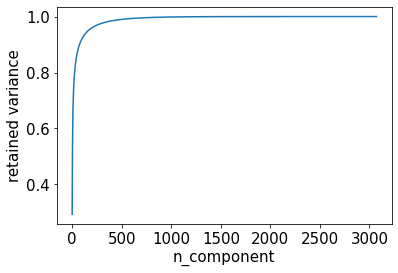

In [224]:
if x0_method == "PCA":
    x_0 = sample_x0_pca(sigma_pca=sigma_pca, mean_img=mean_img, 
                           batch_size=batch_size, N_components=N_components, retained_variance=retained_variance)

elif x0_method == "MultiNormal":
    
    buffer = init_from_centers(dataset, buffer_size=buffer_size, n_class=n_class)
    x_0 = sample_p_0(replay_buffer=buffer, bs=batch_size, y=labels, n_class=n_class)[0]
    
    

#### Plot the $\mathbf{x}_0$ images

In [225]:
x_0.shape

torch.Size([32, 3, 32, 32])

Text(0.5, 0, 'Initial X_0 images in the mode PreJEAT')

<Figure size 576x360 with 0 Axes>

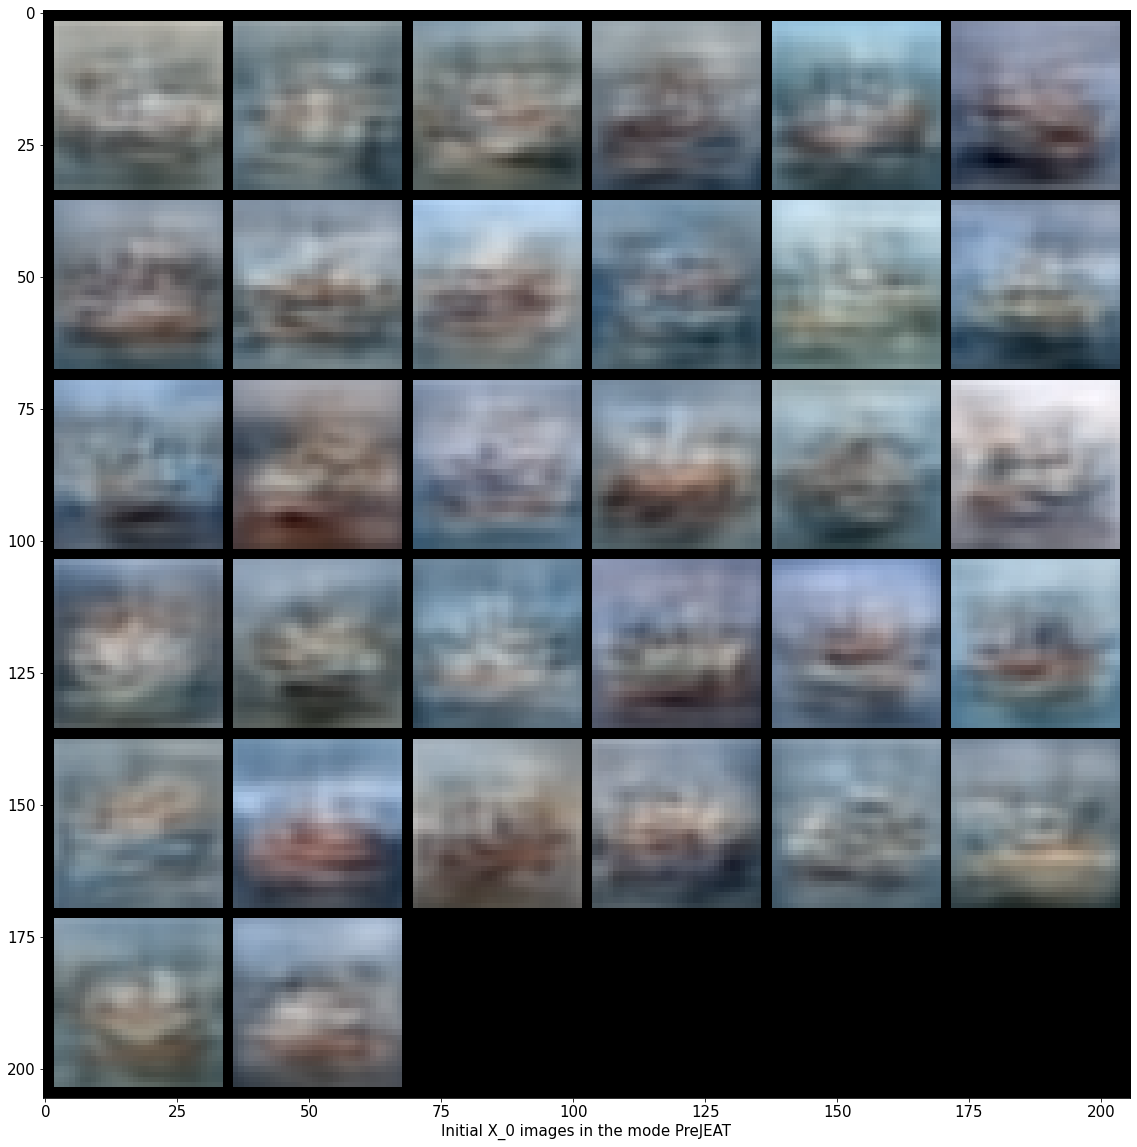

In [226]:
fig = plt.figure(figsize=(8, 5))
columns = 6
rows = 2

grid = torchvision.utils.make_grid(x_0.cpu(), nrow=x_0.shape[0]//5, normalize=True)
grid = grid.permute(1, 2, 0)
plt.figure(figsize=(20,20))
plt.imshow(grid)
plt.xlabel("Initial X_0 images in the mode " + mode)

print the x_0

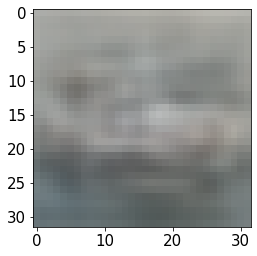

In [227]:
plt.imshow(imgpt_to_np(x_0[0]))

**Sampling with SGLD**

In [249]:
torch.set_grad_enabled(True)  # Tracking gradients for sampling necessary

steps = 15
step_size = 0.5

#SAMPLE
imgs_generated = SGLD(model, x_0, batch_size=batch_size, labels=labels, steps=steps, step_size=step_size, mode=mode)

<Figure size 720x720 with 0 Axes>

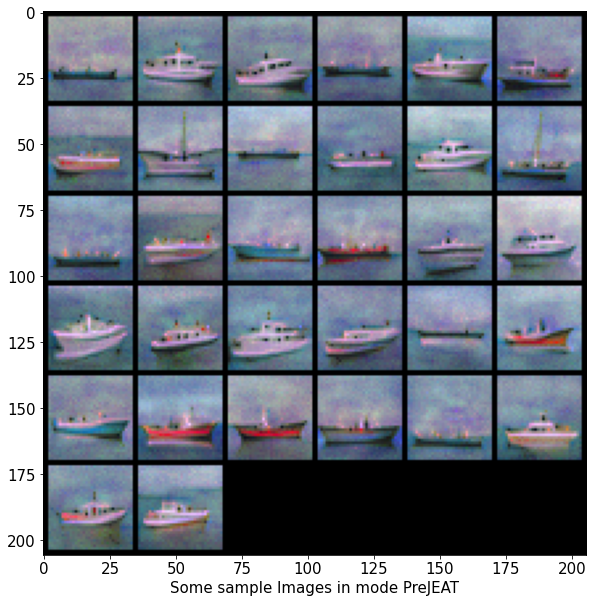

In [250]:
fig = plt.figure(figsize=(10, 10))

grid = torchvision.utils.make_grid(imgs_generated.cpu(), nrow=imgs_generated.shape[0]//5, normalize=False)
grid = grid.permute(1, 2, 0)
plt.figure(figsize=(10,10))
plt.imshow(grid)
plt.xlabel("Some sample Images in mode " + mode)

plt.savefig("./plot.png", format="png")

In [190]:
! pip3 freeze > requirements.txt  # Python3